In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  14.5M      0  0:00:05  0:00:05 --:--:-- 16.3M


Found 15000 files belonging to 2 classes.
Using 12000 files for training.
Found 15000 files belonging to 2 classes.
Using 3000 files for validation.
Found 25000 files belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                2568448   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
  

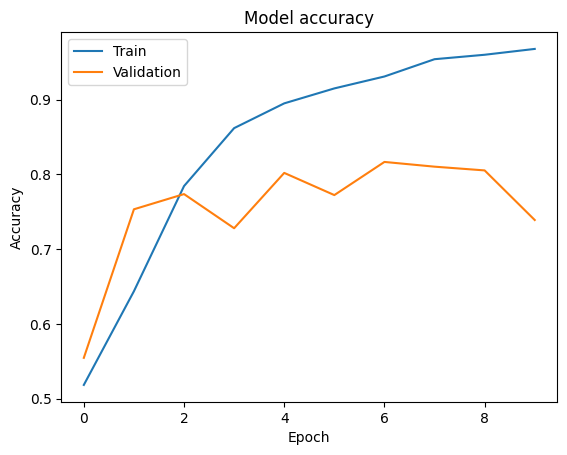

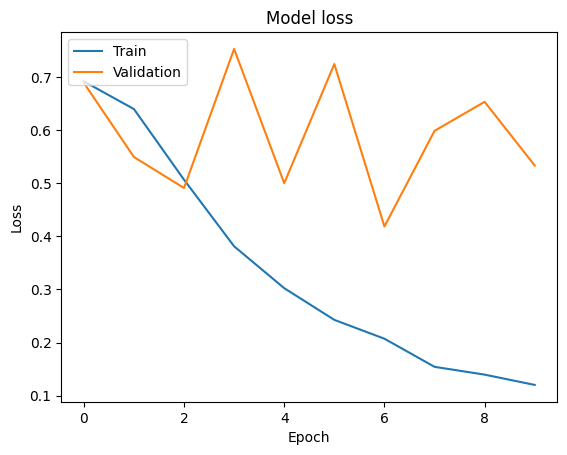

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras

batch_size = 32
length = 150
tokens = 10000
train_samples = 100
val_samples = 10000

base = pathlib.Path("aclImdb")
val = base / "val"
train= base / "train"

for category in ("neg", "pos"):
    os.makedirs(val / category, exist_ok=True)
    files = os.listdir(train / category)
    random.Random(1337).shuffle(files)
    num_val_samples_cat = int(val_samples/2)
    val_files = files[-num_val_samples_cat:]
    for fname in val_files:
        shutil.move(train / category / fname,
                    val / category / fname)

training = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337)

training = training.take(train_samples)

valid_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=1337)

valid_ds = valid_ds.take(val_samples)

testing_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

text_only_train_ds = training.map(lambda x, y: x)

from tensorflow.keras import layers

text_vectorization = layers.TextVectorization(
    max_tokens=tokens,
    output_mode="int",
    output_sequence_length=length,
)

text_vectorization.adapt(text_only_train_ds)

int_train_ds = training.map(lambda x, y: (text_vectorization(x), y),
                            num_parallel_calls=4)

int_val_ds = valid_ds.map(lambda x, y: (text_vectorization(x), y),
                        num_parallel_calls=4)

int_test_ds = testing_ds.map(lambda x, y: (text_vectorization(x), y),
                          num_parallel_calls=4)

import tensorflow as tf

input1 = keras.Input(shape=(None,), dtype="int64")
embedded1 = tf.one_hot(input1, depth=tokens)
a = layers.Bidirectional(layers.LSTM(32))(embedded1)
a = layers.Dropout(0.5)(a)
outputs = layers.Dense(1, activation="sigmoid")(a)
model1 = keras.Model(input1, outputs)

model1.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model1.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras", save_best_only=True)
]




history1 = model1.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks
)

model1 = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model1.evaluate(int_test_ds)[1]:.3f}")
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

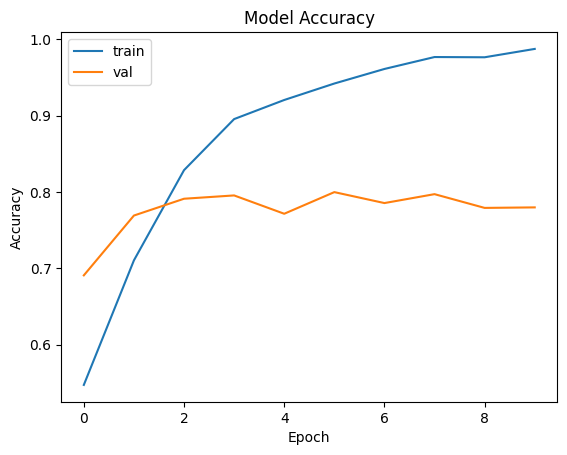

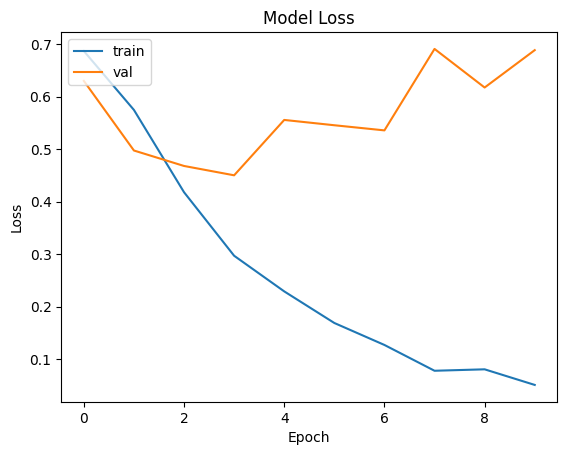

In [ ]:
import matplotlib.pyplot as plt

input2 = keras.Input(shape=(None,), dtype="int64")
embedded2 = layers.Embedding(input_dim=tokens, output_dim=256)(input2)
b = layers.Bidirectional(layers.LSTM(32))(embedded2)
b = layers.Dropout(0.5)(b)
outputs = layers.Dense(1, activation="sigmoid")(b)
model2 = keras.Model(input2, outputs)
model2.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model2.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]

history2 = model2.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

model2 = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model2.evaluate(int_test_ds)[1]:.3f}")

# Plot the training and validation accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

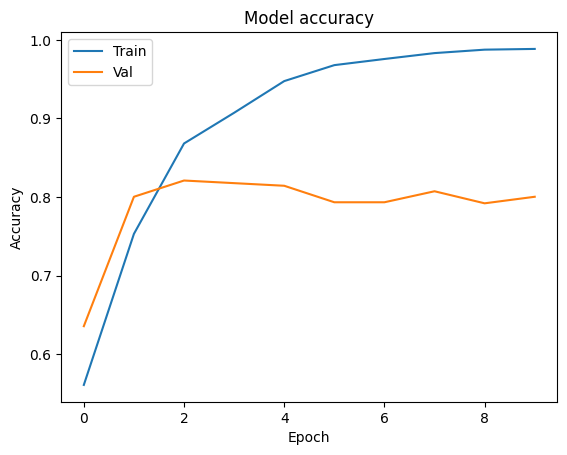

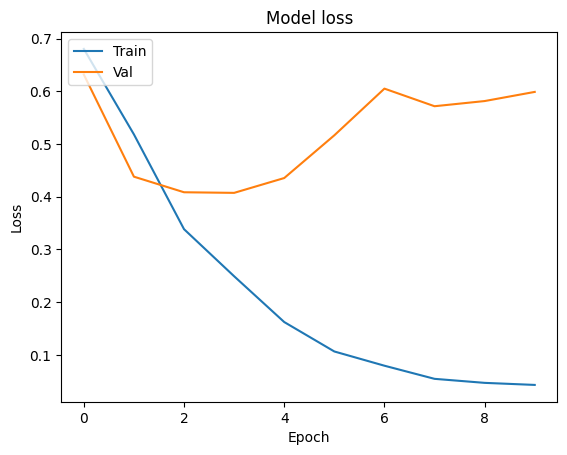

In [ ]:
import matplotlib.pyplot as plt

# Define the model architecture
input3 = keras.Input(shape=(None,), dtype="int64")
embedded3 = layers.Embedding(input_dim=tokens, output_dim=256, mask_zero=True)(input3)
c = layers.Bidirectional(layers.LSTM(32))(embedded3)
c = layers.Dropout(0.5)(c)
outputs = layers.Dense(1, activation="sigmoid")(c)
model3 = keras.Model(input3, outputs)

# Compile the model
model3.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model3.summary()

# Define the callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True),
    keras.callbacks.History()
]

# Train the model
history3 = model3.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

# Load the best model
model3 = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model3.evaluate(int_test_ds)[1]:.3f}")

# Plot the training and validation accuracy and loss
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")



--2024-04-20 23:16:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-20 23:16:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-20 23:16:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [43]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  15.9M      0  0:00:05  0:00:05 --:--:-- 17.1M


In [44]:
embedding = 100
tokens = 10000
len = 150
samples = 100
validation = 10000

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary,range(tokens)))
word_index = {k: v for k, v in word_index.items() if v < tokens}

embedding_matrix = np.zeros((tokens, embedding))
for word, i in word_index.items():
    if i < tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    tokens,
    embedding,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

input4 = keras.Input(shape=(None,), dtype="int64")
embedded4 = embedding_layer(input4)
d = layers.Bidirectional(layers.LSTM(32))(embedded4)
d = layers.Dropout(0.5)(d)
outputs = layers.Dense(1, activation="sigmoid")(d)
model4 = keras.Model(input4, outputs)
model4.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model4.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]


history4 = model4.fit(int_train_ds.take(samples).cache(),
          validation_data=int_val_ds.take(validation).cache(),
          epochs=10, callbacks=callbacks)

model4 = keras.models.load_model("glove_embeddings_sequence_model.keras")
_, test_acc = model4.evaluate(int_test_ds.take(validation))
print(f"Test acc: {test_acc:.3f}")



Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_17 (Embedding)    (None, None, 100)         1000000   
                                                                 
 bidirectional_18 (Bidirect  (None, 64)                34048     
 ional)                                                          
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1034113 (3.94 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 1000000 (3.81 MB)
________________

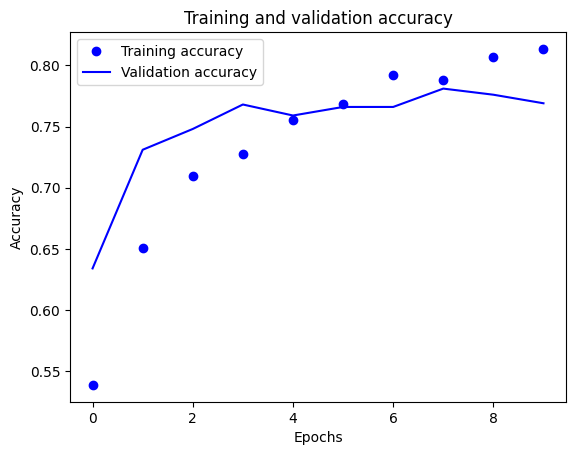

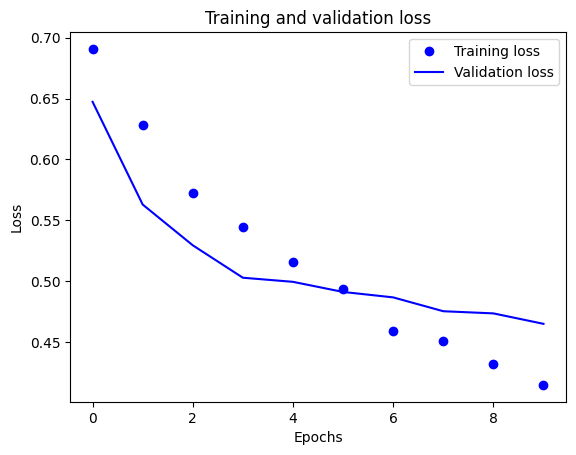

In [47]:
# Plot training and validation accuracy
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

plt.plot( acc, 'bo', label='Training accuracy')
plt.plot( val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
loss = history4.history['loss']
val_loss = history4.history['val_loss']
plt.plot( loss, 'bo', label='Training loss')
plt.plot( val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 25000 files belonging to 2 classes.
Found 15000 files belonging to 2 classes.
Using 12000 files for training.
Found 15000 files belonging to 2 classes.
Using 12000 files for training.
Found 15000 files belonging to 2 classes.
Using 3000 files for validation.
Epoch 1/10
375/375 [==============================] - 34s 72ms/step - loss: 0.5385 - accuracy: 0.7098 - val_loss: 0.4047 - val_accuracy: 0.8153
Epoch 2/10
375/375 [==============================] - 17s 44ms/step - loss: 0.3429 - accuracy: 0.8574 - val_loss: 0.3597 - val_accuracy: 0.8400
Epoch 3/10
375/375 [==============================] - 15s 39ms/step - loss: 0.2615 - accuracy: 0.8986 - val_loss: 0.5987 - val_accuracy: 0.8030
Epoch 4/10
375/375 [==============================] - 11s 29ms/step - loss: 0.2032 - accuracy: 0.9253 - val_loss: 0.4133 - val_accuracy: 0.8370
Epoch 5/10
375/375 [==============================] - 12s 32ms/step - loss: 0.1591 - accuracy: 0.9426 - val_loss: 0.4863 - val_accuracy: 0.8337
Epoch 6/10
375/

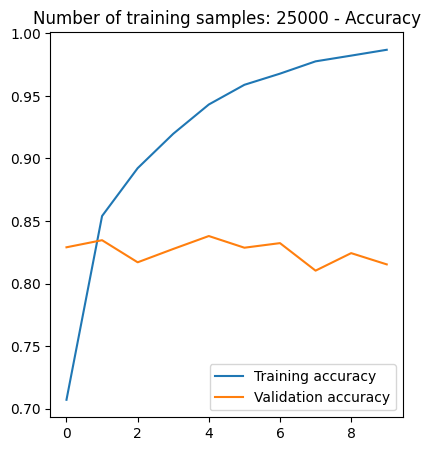

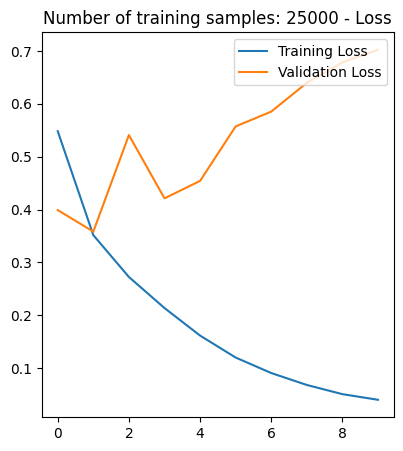

In [48]:
import os, pathlib, shutil, random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 32
length = 150
tokens = 10000
val_samples = 10000

base = pathlib.Path("aclImdb")
val = base / "val"
train = base / "train"

for category in ("neg", "pos"):
    os.makedirs(val / category, exist_ok=True)
    files = os.listdir(train / category)
    random.Random(1337).shuffle(files)
    num_val_samples_cat = int(val_samples/2)
    val_files = files[-num_val_samples_cat:]
    for fname in val_files:
        shutil.move(train / category / fname,
                    val / category / fname)

test = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

text_only_train = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337).map(lambda x, y: x)

text_vectorization = layers.TextVectorization(
    max_tokens=tokens,
    output_mode="int",
    output_sequence_length=length,
)

text_vectorization.adapt(text_only_train)

for num_train_samples in [1000, 5000, 10000, 15000, 20000, 25000]:
    train_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='training',
        seed=1337
    ).take(num_train_samples)

    val_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='validation',
        seed=1337
    ).take(val_samples)

    int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_test_ds = test.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

    input5 = keras.Input(shape=(None,), dtype="int64")
    embedded5= layers.Embedding(
        input_dim=tokens, output_dim=256, mask_zero=True)(input5)
    e = layers.Bidirectional(layers.LSTM(32))(embedded5)
    e = layers.Dropout(0.5)(e)
    outputs = layers.Dense(1, activation="sigmoid")(e)
    model5 = keras.Model(input5, outputs)
    model5.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint(f"embeddings_bidir_gru_with_masking_{num_train_samples}.keras",
                                        save_best_only=True)
    ]
    history5 = model5.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

    model5 = keras.models.load_model(f"embeddings_bidir_gru_with_masking_{num_train_samples}.keras")
    test_acc = model5.evaluate(int_test_ds)[1]
    print(f"Number of training samples: {num_train_samples} - Test accuracy: {test_acc:.3f}")

# Plot the training and validation loss
loss = history5.history['loss']
val_loss = history5.history['val_loss']



#Plot the training and validation accuracies
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot( acc, label='Training accuracy')
plt.plot( val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title(f'Number of training samples: {num_train_samples} - Accuracy')
plt.show()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Number of training samples: {num_train_samples} - Loss')
plt.show()



